## Single-pass Mesh Registration from 3D Scans (FAUST evaluation)

#### This notebook will:

#### 1. Load and process [FAUST dataset](http://faust.is.tue.mpg.de/) (you will need to download it first);
#### 2. Convert FAUST scans into BPS representation (see [Section 3.1](https://arxiv.org/pdf/1908.09186.pdf) of the original paper for details);
#### 3. Define and load pre-trained BPS mesh registration model (see [Section 5.2](https://arxiv.org/pdf/1908.09186.pdf) of the original paper for details);
#### 4. Run the model on converted FAUST scans;
#### 5. Visualize the results;
#### 6. Compute the correspondences for test FAUST scans for the final evaluation.

#### The results of this notebook (predicted alignments, computed correspondeces, demo video) are also available 

![Teaser Image](../faust_examples.gif)

### 0. Download [FAUST dataset](http://faust.is.tue.mpg.de/) and [checkpoint model](https://www.dropbox.com/s/u3d1uighrtcprh2/mesh_regressor.h5?dl=0) ([mirror](https://drive.google.com/open?id=19uJp7jeQRdx3rviE7VFD5GkglxvFbzfh)) and change the corresponding paths 

In [23]:
# change this to your actual data path!
FAUST_DATA_PATH = '../data/MPI-FAUST/'
CKPT_DATA_PATH = '../data/mesh_regressor.h5'

### 1. Load [FAUST dataset](http://faust.is.tue.mpg.de/) (please download it first, registration is needed)

In [1]:
"""

FAUST dataset Python loader. The dataset itself can be downloaded here:
http://faust.is.tue.mpg.de/

"""

import os
import numpy as np
from tqdm import tqdm
import trimesh


def get_faust_train(data_dir, n_scan_points=10000):
    """ Get FAUST train scans and ground truth SMPL registrations

    Parameters
    ----------
    data_dir : str
        path to FAUST dataset directory (../MPI-FAUST/)
    n_scan_points: int
        number of points to take from the scan

    Returns
    -------
    scans : numpy array [n_scans, n_scan_points, 3]
        scans point clouds
    meshes : numpy array [n_scans, 6890, 3]
        ground truth SMPL registrations

    """
    n_mesh_vertices = 6890
    n_train_scans = 100

    scans_path = os.path.join(data_dir, 'training/scans/')
    registrations_path = os.path.join(data_dir, 'training/registrations/')

    scans = np.zeros([n_train_scans, n_scan_points, 3])
    meshes = np.zeros([n_train_scans, n_mesh_vertices, 3])

    for fid in tqdm(range(0, n_train_scans)):
        mesh_scan = trimesh.load_mesh(os.path.join(scans_path, 'tr_scan_%03d.ply' % fid))
        x = np.asarray(mesh_scan.sample(n_scan_points))

        mesh_reg = pynt.PyntCloud.from_file(os.path.join(registrations_path, 'tr_reg_%03d.ply' % fid))
        y = mesh_reg.xyz

        scans[fid] = x
        meshes[fid] = y

    return scans, meshes


def get_faust_scan_by_id(data_dir, scan_id, part='test', mesh_lib='trimesh'):
    """Get FAUST scan by its id

    """
    if part == 'test':
        scans_path = os.path.join(data_dir, 'test/scans/')
    else:
        scans_path = os.path.join(data_dir, 'training/scans/')

    mesh_path = os.path.join(scans_path, 'test_scan_%03d.ply' % scan_id)

    mesh_scan = trimesh.load_mesh(mesh_path)
    
    return mesh_scan


def get_faust_test(data_dir, n_scan_points=10000):
    """ Get FAUST test scans

    Parameters
    ----------
    data_dir : str
        path to FAUST dataset directory (../MPI-FAUST/)
    n_scan_points: int
        number of points to take from the scan

    Returns
    -------
    scans : numpy array [n_scans, n_scan_points, 3]
        scans point clouds

    """
    n_test_scans = 200

    scans_path = os.path.join(data_dir, 'test/scans/')

    scans = np.zeros([n_test_scans, n_scan_points, 3])

    for fid in tqdm(range(0, n_test_scans)):
        mesh_scan = trimesh.load_mesh(os.path.join(scans_path, 'test_scan_%03d.ply' % fid))
        x = np.asarray(mesh_scan.sample(n_scan_points))

        scans[fid] = x

    return scans

In [2]:
train_scans, train_meshes = get_faust_train(FAUST_DATA_PATH)
test_scans = get_faust_test(FAUST_DATA_PATH)

100%|██████████| 200/200 [00:43<00:00,  4.61it/s]


### 2. Convert FAUST to BPS representation 

In [3]:
from bps import bps

BPS_RADIUS = 1.7
N_BPS_POINTS = 1024
MESH_SCALER = 1000

xtr, xtr_mean, xtr_max = bps.normalize(train_scans, max_rescale=False, return_scalers=True)
ytr = bps.normalize(train_meshes, x_mean=xtr_mean, x_max=xtr_max, known_scalers=True, max_rescale=False)
xtr_bps = bps.encode(xtr, radius=BPS_RADIUS, n_bps_points=N_BPS_POINTS, bps_cell_type='dists')

xte, xte_mean, xte_max = bps.normalize(test_scans, max_rescale=False, return_scalers=True)
xte_bps = bps.encode(xte, radius=BPS_RADIUS, n_bps_points=N_BPS_POINTS, bps_cell_type='dists')

using 4 available CPUs for BPS encoding..


100%|██████████| 25/25 [00:00<00:00, 52.54it/s]


using 4 available CPUs for BPS encoding..


100%|██████████| 50/50 [00:01<00:00, 46.72it/s]


### 3. Define and load the pre-trained model (please download the checkpoint from [here](https://www.dropbox.com/s/u3d1uighrtcprh2/mesh_regressor.h5?dl=0), [mirror](https://drive.google.com/open?id=19uJp7jeQRdx3rviE7VFD5GkglxvFbzfh))

![Teaser Image](../bps_demo.png)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MeshRegressorMLP(nn.Module):

    def __init__(self, n_features, hsize=1024):
        super(MeshRegressorMLP, self).__init__()

        self.bn0 = nn.BatchNorm1d(n_features)
        self.fc1 = nn.Linear(in_features=n_features, out_features=hsize)
        self.bn1 = nn.BatchNorm1d(hsize)
        self.fc2 = nn.Linear(in_features=hsize, out_features=hsize)
        self.bn2 = nn.BatchNorm1d(hsize)

        self.fc3 = nn.Linear(in_features=hsize + n_features, out_features=hsize)
        self.bn3 = nn.BatchNorm1d(hsize)
        self.fc4 = nn.Linear(in_features=hsize, out_features=hsize)
        self.bn4 = nn.BatchNorm1d(hsize)

        self.fc5 = nn.Linear(in_features=hsize*2 + n_features, out_features=6890*3)

    def forward(self, x):

        x = self.bn0(x)
        x0 = x
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x1 = x
        x = torch.cat([x0, x], 1)
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.bn4(F.relu(self.fc4(x)))

        x = torch.cat([x0, x1, x], 1)

        x = self.fc5(x).reshape([-1, 6890, 3])

        return x

In [5]:
# change this to your actual checkpoint path

model = MeshRegressorMLP(n_features=N_BPS_POINTS)

model.load_state_dict(torch.load(CKPT_DATA_PATH, map_location='cpu'))

model.eval()

MeshRegressorMLP(
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=3072, out_features=20670, bias=True)
)

### 4. Run the model on FAUST data

In [6]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def chamfer_distance(x, y, metric='l2', direction='bi'):
    """Chamfer distance between two point clouds

    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
        first point cloud
    y: numpy array [n_points_y, n_dims]
        second point cloud
    metric: string or callable, default ‘l2’
        metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
    direction: str
        direction of Chamfer distance.
            'y_to_x':  computes average minimal distance from every point in y to x
            'x_to_y':  computes average minimal distance from every point in x to y
            'bi': compute both
    Returns
    -------
    chamfer_dist: float
        computed bidirectional Chamfer distance:
            sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
    """
    
    if direction=='y_to_x':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        chamfer_dist = np.mean(min_y_to_x)
    elif direction=='x_to_y':
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_x_to_y)
    elif direction=='bi':
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
    else:
        raise ValueError("Invalid direction type. Supported types: \'y_x\', \'x_y\', \'bi\'")
        
    return chamfer_dist

In [7]:
LOG_DIR = '../logs/'

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

ytr_preds = model(torch.Tensor(xtr_bps)).detach().numpy() 
ytr_preds /= MESH_SCALER

yte_preds = model(torch.Tensor(xte_bps)).detach().numpy() 
yte_preds /= MESH_SCALER

scan_to_mesh_loss = []
for fid in range(0, len(yte_preds)):
    yte_preds[fid] += xte_mean[fid]
    scan_to_mesh_loss.append(MESH_SCALER*chamfer_distance(yte_preds[fid], xte[fid]+xte_mean[fid], direction='y_to_x'))

alignments_path = os.path.join(LOG_DIR, 'alignments.npy')
np.save(alignments_path, yte_preds)

print("FAUST test set scan-to-mesh distance (avg): %4.2f mms" % np.mean(scan_to_mesh_loss))

FAUST test set scan-to-mesh distance (avg): 15.07 mms


### 5. Visualize predicted meshes

In [8]:
import trimesh

INTENSE_GREEN = [0,255,128]
INTENSE_BLUE = [0,128,255]

def merge_meshes(mesh1, mesh2):
    """Merge two trimesh meshes for easy visualisation
    
    """
    
    verts1 = np.asarray(mesh1.vertices)
    faces1 = np.asarray(mesh1.faces)
    
    verts2 = np.asarray(mesh2.vertices)
    faces2 = np.asarray(mesh2.faces)
    
    n_faces1 = len(faces1)
    n_verts1 = len(verts1)

    vertices_pair = np.concatenate([verts1, verts2])
    faces_pair = np.concatenate([faces1, faces2+n_verts1])
    face_colors_pair = np.zeros_like(faces_pair) 
    face_colors_pair[0:n_faces1, :] += INTENSE_GREEN
    face_colors_pair[n_faces1:, :] += INTENSE_BLUE

    mesh = trimesh.Trimesh(vertices=vertices_pair, faces=faces_pair, face_colors=face_colors_pair)
    
    return mesh

smpl_faces = np.loadtxt('../bps_demos/smpl_mesh_faces.txt')

In [ ]:
import PIL
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


N_TEST_SCANS = 200

IMAGES_DIR = os.path.join(LOG_DIR, 'faust_test_images')

if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    
ALIGNS_DIR = os.path.join(LOG_DIR, 'faust_test_alignments')

if not os.path.exists(ALIGNS_DIR):
    os.makedirs(ALIGNS_DIR)

for fid in tqdm(range(120, N_TEST_SCANS)):
    
    mesh_scan = get_faust_scan_by_id(FAUST_DATA_PATH, fid, 'test')

    mesh_scan = trimesh.Trimesh(vertices=mesh_scan.vertices, faces=mesh_scan.faces, face_colors=INTENSE_GREEN)
    mesh_preds = trimesh.Trimesh(vertices=yte_preds[fid], faces=smpl_faces, face_colors=INTENSE_BLUE)

    mesh_pair = merge_meshes(mesh_scan, mesh_preds)
    
    scan_img_path = os.path.join(IMAGES_DIR, '%03d_01_scan.png'%fid)
    alignment_img_path = os.path.join(IMAGES_DIR, '%03d_02_pred.png'%fid)
    pair_image_path = os.path.join(IMAGES_DIR, '%03d_03_pair.png'%fid)
    merged_img_path =  os.path.join(IMAGES_DIR, '%03d_scan_align_pair.png'%fid)
    alignment_obj_path = os.path.join(ALIGNS_DIR, '%03d_align.obj'%fid)
    
    with open(scan_img_path, 'wb') as f:
        f.write(mesh_scan.scene().save_image())

    with open(alignment_img_path, 'wb') as f:
        f.write(mesh_preds.scene().save_image())
        
    with open(pair_image_path, 'wb') as f:
        f.write(mesh_pair.scene().save_image())

    scan_img = np.asarray(PIL.Image.open(scan_img_path))[:, 600:1200]
    align_img = np.asarray(PIL.Image.open(alignment_img_path))[:, 600:1200]
    pair_img = np.asarray(PIL.Image.open(pair_image_path))[:, 600:1200]

    fig = plt.figure(figsize=(30, 10))
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('Input Scan', size=25)
    plt.imshow(scan_img)

    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title('Predicted Alignment', size=25)
    plt.imshow(align_img)

    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Overlay (scan2mesh: %3.1f mms)' % scan_to_mesh_loss[fid], size=25)
    plt.imshow(pair_img)
    fig.suptitle("FAUST Test Scan ID: %03d" % fid, size=15, fontweight="bold")
    
    plt.savefig(merged_img_path, dpi=200)
    
    os.remove(scan_img_path)
    os.remove(alignment_img_path)
    os.remove(pair_image_path)
    
    res = mesh_preds.export(alignment_obj_path)

In [14]:
print("Predicted alignments meshes saved in: %s" % ALIGNS_DIR)
print("Predicted alignments images saved in: %s" % IMAGES_DIR)

Predicted alignments meshes saved in: ../logs/faust_test_alignments
Predicted alignments images saved in: ../logs/faust_test_images


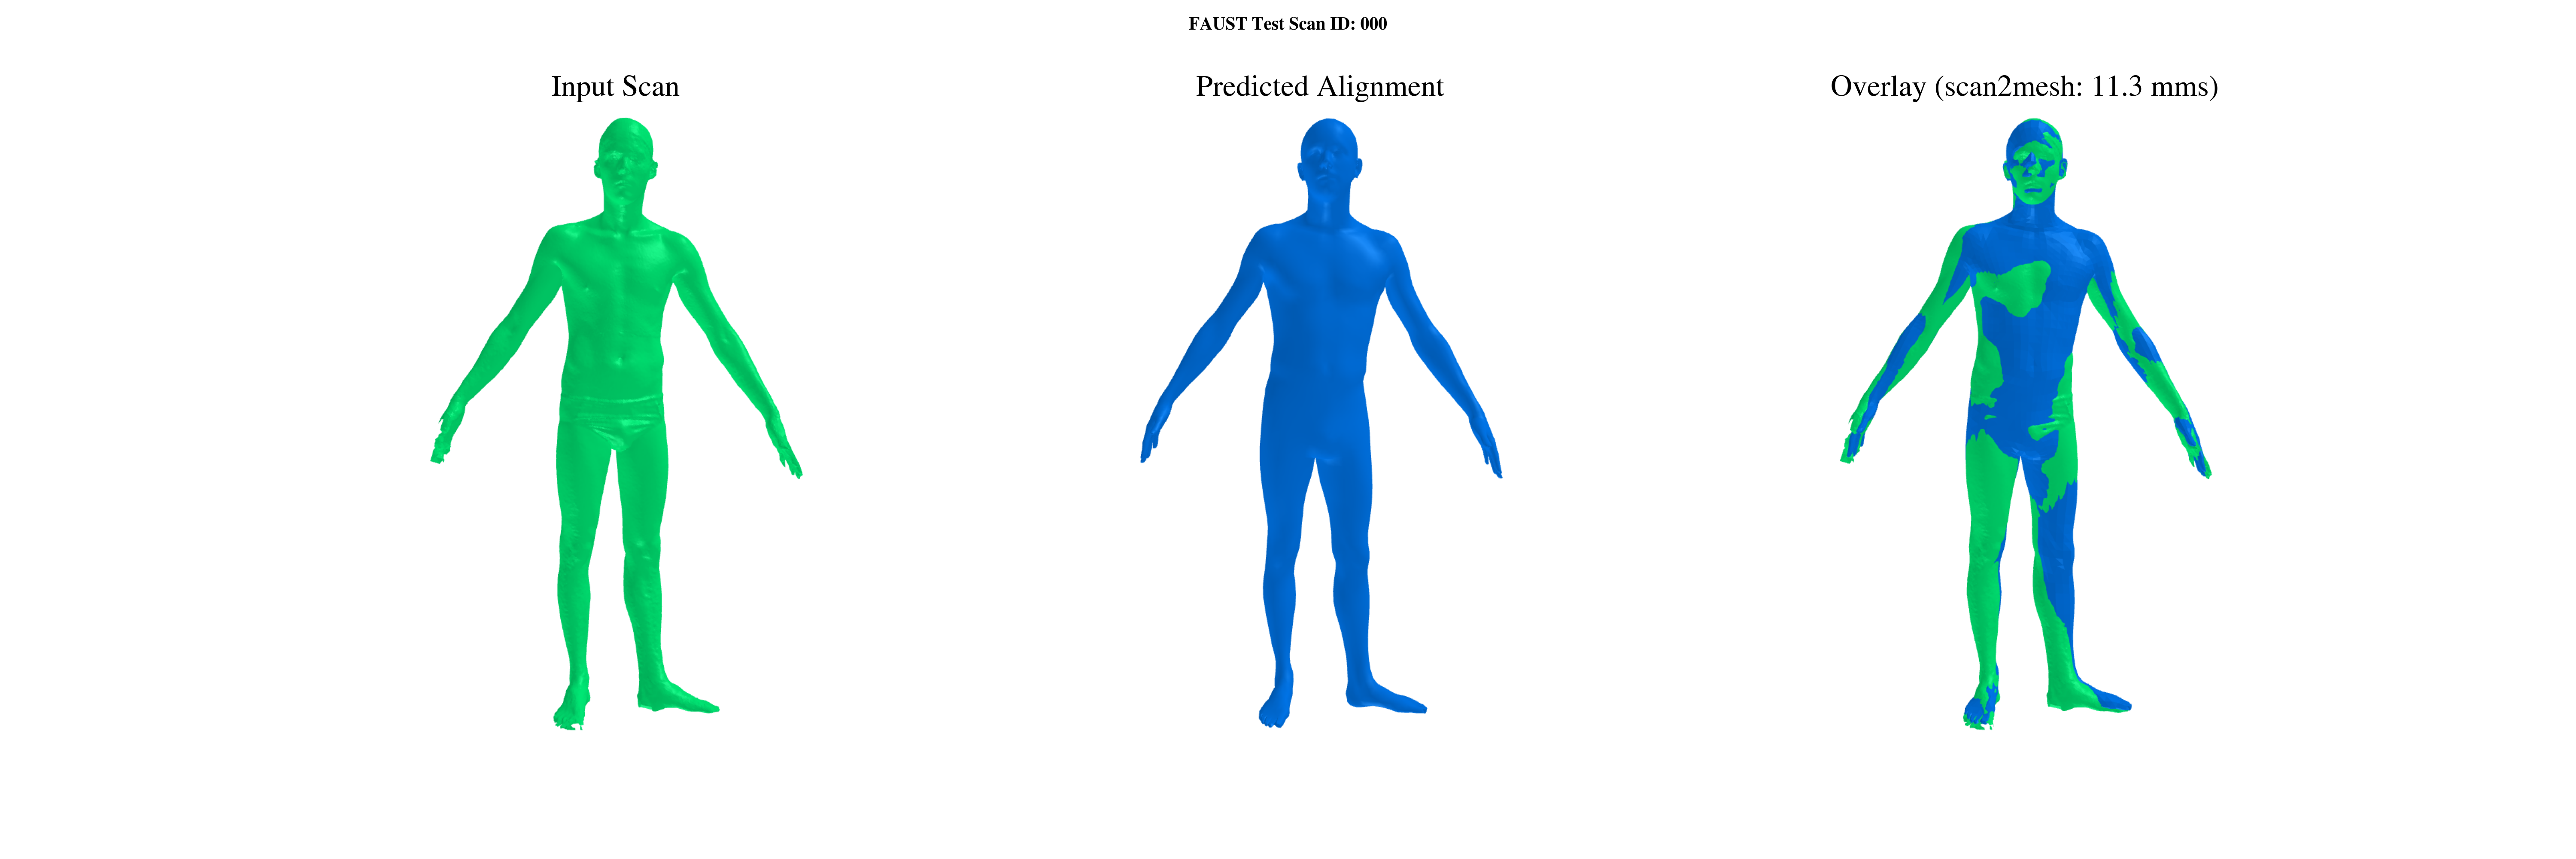

In [26]:
fid = 0
merged_img_path =  os.path.join(IMAGES_DIR, '%03d_scan_align_pair.png'%fid)
PIL.Image.open(merged_img_path)

#### Optional: make demo video with predictions

In [19]:
PREDICTIONS_VIDEO_PATH = os.path.join(LOG_DIR, 'faust_test_demo.mp4')
ffmpeg_cmd = 'ffmpeg -framerate 0.5 -pattern_type glob -i \'%s/*.png\' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  %s' % (IMAGES_DIR, PREDICTIONS_VIDEO_PATH)
os.system(ffmpeg_cmd)
print("predictions video saved at : %s" % PREDICTIONS_VIDEO_PATH)

0

### 6. Compute correspondences for FAUST test pairs
##### Produced correspondences achieve 2.631cm/4.785cm average error on INTRA/INTER challenges respectively.

In [21]:
from psbody.mesh import Mesh
from os.path import join
import numpy as np
import shutil

def compute_correspondences_on_faust_test_pairs(alignment_verts, faust_data_path, output_dir, mesh_faces, mode='intra'):
    
    assert(mode in ('intra', 'inter'))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    
    pairs_path = os.path.join(faust_data_path, 'test/challenge_pairs/{}_challenge.txt'.format(mode))
    scan_dir = os.path.join(faust_data_path, 'test/scans')
    
    with open(pairs_path, 'r') as f:
        for ipair, pair in tqdm(enumerate(f.readlines())):
            src_scan, dst_scan = [Mesh(filename=join(scan_dir, 'test_scan_{}.ply'.format(idx)))
                                  for idx in pair.strip().split('_')]
            src_algn, dst_algn = [Mesh(v=alignment_verts[int(pair.strip().split('_')[i])], f=mesh_faces) for i in range(2)]
            faces, pts = src_algn.closest_faces_and_points(src_scan.v)
            v_idxs, bary = src_algn.barycentric_coordinates_for_points(pts, faces)
            corrs = np.einsum('ijk,ij->ik', dst_algn.v[v_idxs], bary)
            np.savetxt(join(output_dir, '{}.txt'.format(pair.strip())), corrs)

In [22]:
INTRA_SAVE_PATH = os.path.join(LOG_DIR, 'intra')
INTER_SAVE_PATH = os.path.join(LOG_DIR, 'inter')

compute_correspondences_on_faust_test_pairs(yte_preds, faust_data_path=FAUST_DATA_PATH, output_dir=INTRA_SAVE_PATH, mesh_faces=smpl_faces, mode='intra')
compute_correspondences_on_faust_test_pairs(yte_preds, faust_data_path=FAUST_DATA_PATH, output_dir=INTER_SAVE_PATH, mesh_faces=smpl_faces, mode='inter')

INTRA_ZIP_PATH = os.path.join(LOG_DIR, 'intra.zip')
INTER_ZIP_PATH = os.path.join(LOG_DIR, 'inter.zip')

os.system('zip -r %s %s' % (INTRA_ZIP_PATH, INTRA_SAVE_PATH))
os.system('zip -r %s %s' % (INTER_ZIP_PATH, INTER_SAVE_PATH))

print("FAUST-INTRA test submission archive saved at: %s" % INTRA_ZIP_PATH)
print("FAUST-INTER test submission archive saved at: %s" % INTER_ZIP_PATH)

60it [01:37,  1.63s/it]
40it [01:02,  1.57s/it]


FAUST-INTRA test submission archive saved at: ../logs/intra.zip
FAUST-INTER test submission archive saved at: ../logs/inter.zip
